# Pulse simulation demo

In [1]:
import copy
import numpy as np
import logging
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
import scipy.optimize as sciopt
import h5py
from IPython.display import Math
import qutip as qtp

from qudit_sim import (find_heff, run_pulse_sim, make_generalized_paulis,
                       matrix_ufunc, extract_coefficients,
                       FrequencyScale)
from qudit_sim.heff import (heff_expr, inspect_fidelity_maximization,
                            plot_amplitude_scan, coeffs_bar)

twopi = 2. * np.pi

## Input parameters

In [2]:
#from qiskit import IBMQ

#IBMQ.load_account()
#provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
#backend = provider.get_backend('ibmq_lima')

#params = backend.configuration().hamiltonian['vars']

params = {
    'delta0': -2.11e+9,
    'delta1': -2.00e+9,
    'jq0q1': 1.11e+7,
    'omegad0': 1.61e+9,
    'omegad1': 1.33e+9,
    'wq0': 3.16e+10,
    'wq1': 3.22e+10
}

## [Demo 1] Single qutrit, qubit-resonant drive simulation, effective qubit Hamiltonian

In [3]:
# Drive definition: square (i.e. constant) drive to channel 0 (connected to qubit 0) at the resonant frequency
# 'amplitude' is relative to the full drive amplitude ('omegad0' in params)
drive_def = {0: {'frequency': params['wq0'], 'amplitude': 0.1}}

heff = find_heff(
    qubits=0,
    params=params,
    drive_def=drive_def,
    num_sim_levels=3,
    comp_dim=2,
    method='fidelity',
    save_result_to='demo1',
    log_level=logging.INFO)

INFO:qudit_sim.find_heff:Running a square pulse simulation for 100 cycles
INFO:qudit_sim.pulse_sim:Instantiated a Hamiltonian generator for 1 qubits and 3 levels
INFO:qudit_sim.pulse_sim:Number of interaction terms: 0
INFO:qudit_sim.pulse_sim:Adding a drive with frequency 31600000000.000000 and envelope 0.1
INFO:qudit_sim.pulse_sim:Number of drive terms: 2
INFO:qudit_sim.pulse_sim:Using 1000 time points from 0.000e+00 to 2.978e-07
INFO:qudit_sim.pulse_sim:Hamiltonian with 3 terms generated. Starting simulation..
INFO:qudit_sim.pulse_sim:Done in 4.913829 seconds.
INFO:qudit_sim.pulse_sim:Saving the simulation result to demo1.qu
INFO:qudit_sim.heff.fidelity_maximization:Starting maximization loop..
INFO:qudit_sim.heff.fidelity_maximization:Done after 91 steps.
INFO:qudit_sim.heff.fidelity_maximization:Adjusting the coefficients from a linear fit to the residuals..


### Effective Hamiltonian

In [4]:
Math(heff_expr(heff))

<IPython.core.display.Math object>

### Inspecting the $H_{\mathrm{eff}}$ extraction process

First plot, from left top:


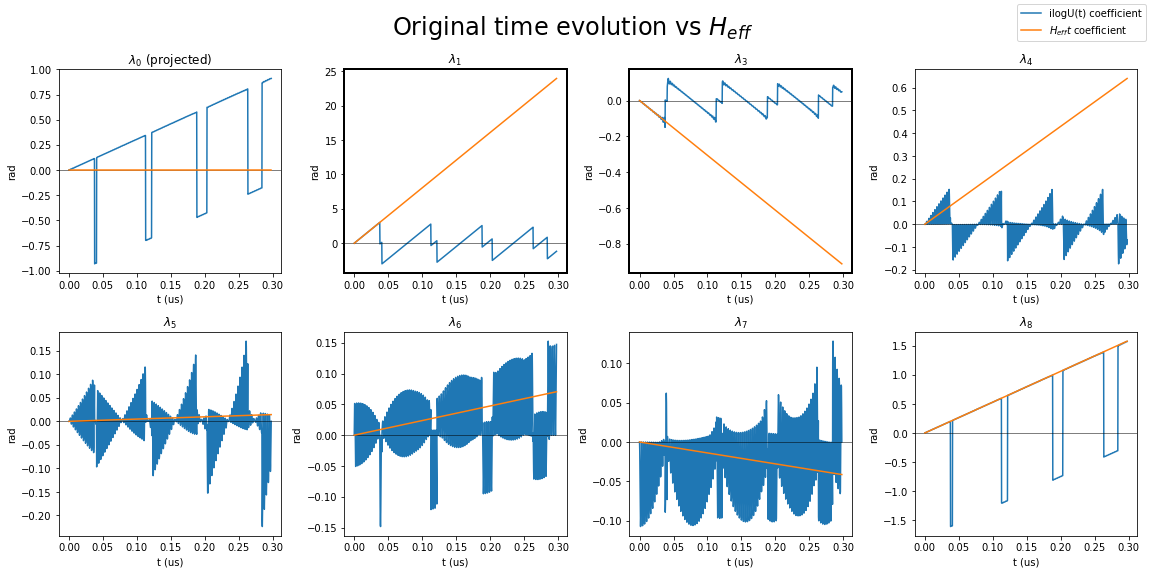

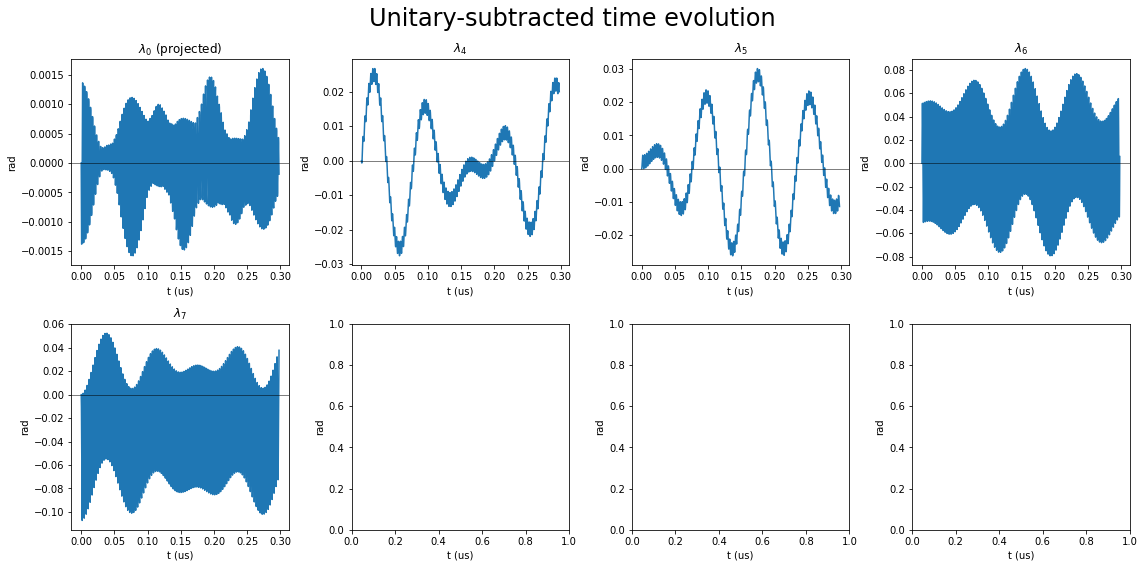

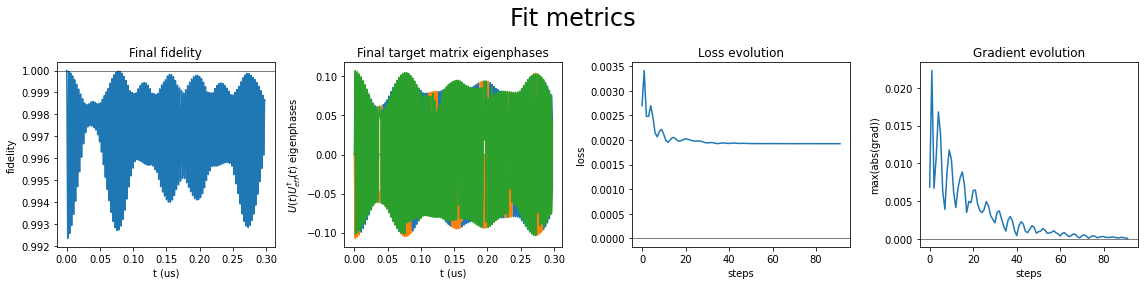

In [5]:
inspect_fidelity_maximization('demo1.h5');

In [6]:
# Raw and processed results from the dynamics simulation is saved to `save_result_to`.h5
with h5py.File('demo1.h5', 'r') as source:
    time_evolution = source['time_evolution'][()]
    tlist = source['tlist'][:]

In [7]:
generators, eigenvalues = matrix_ufunc(lambda u: -np.angle(u), time_evolution, with_diagonals=True)
pauli_coeffs = extract_coefficients(generators, 1)

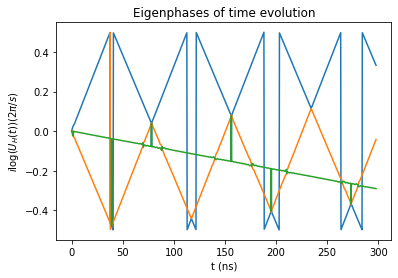

In [8]:
plt.plot(tlist * 1.e+9, eigenvalues / twopi)
plt.title('Eigenphases of time evolution')
plt.ylabel(r'$i\log(U_{H}(t)) (2\pi/s)$')
plt.xlabel('t (ns)');

## [Demo 2] Cross resonance simulated in higher-dimensional spaces

In [9]:
# Drive definition: square (i.e. constant) drive to channel 0 at the frequency of qubit 1
drive_def = {0: {'frequency': params['wq1'], 'amplitude': 0.1}}

# Qutrit simulation
heff_3 = find_heff(
    qubits=(0, 1),
    params=params,
    drive_def=drive_def,
    num_sim_levels=3,
    comp_dim=2)

In [10]:
# Qutrit simulation
heff_4 = find_heff(
    qubits=(0, 1),
    params=params,
    drive_def=drive_def,
    num_sim_levels=4,
    comp_dim=2)

In [11]:
Math(heff_expr(heff_3))

<IPython.core.display.Math object>

In [12]:
Math(heff_expr(heff_4))

<IPython.core.display.Math object>

Simulating in 3 and 4 levels results in small differences for dominant terms (heff_expr only shows terms with absolute coefficients above a threshold, default=0.01MHz).

## [Demo 3] Cross resonance with relative phase offset between the qubits

Real qubits each have a phase offset from the room-temperature electronics. This offset has no effect when driving and reading out a single qubit, but manifests itself as a target X-Y rotation in cross resonance.

In [13]:
# Drive definition: square (i.e. constant) drive to channel 0 at the frequency of qubit 1
drive_def = {0: {'frequency': params['wq1'], 'amplitude': 0.1}}

# Qutrit simulation
heff_offset = find_heff(
    qubits=(0, 1),
    params=params,
    drive_def=drive_def,
    phase_offsets={1: 2.1},
    num_sim_levels=3,
    comp_dim=2)

Math(heff_expr(heff_offset, scale=FrequencyScale.MHz, threshold=(twopi * 1.e+4)))

<IPython.core.display.Math object>

The IY and ZY terms can be cancelled by applying the same offset to the drive, although that will in turn create a YI term.

In [14]:
# Drive definition: square (i.e. constant) drive to channel 0 at the frequency of qubit 1
drive_def = {0: {'frequency': params['wq1'], 'amplitude': 0.1 * np.exp(2.1j)}}

# Qutrit simulation
heff_offset_cancelled = find_heff(
    qubits=(0, 1),
    params=params,
    drive_def=drive_def,
    phase_offsets={1: 2.1},
    num_sim_levels=3,
    comp_dim=2)

Math(heff_expr(heff_offset_cancelled, scale=FrequencyScale.MHz, threshold=(twopi * 1.e+4)))

<IPython.core.display.Math object>

## [Demo 4] Amplitude scan of cross resonance, simulated in the qutrit space

In [15]:
amplitudes = np.linspace(-0.2, 0.2, 20)

drive_def = list({0: {'frequency': params['wq1'], 'amplitude': amp}} for amp in amplitudes)

# When a list is passed as drive_def, pulse simulation and Heff extraction are automatically parallelized
heff_scan = find_heff(
    qubits=(0, 1),
    params=params,
    drive_def=drive_def,
    num_sim_levels=3,
    comp_dim=2,
    jax_devices=[0, 1])

Residual adjustment is performed to suppress spurious Heff terms and usually concerns small values, so we can ignore the warnings in a use case like this.

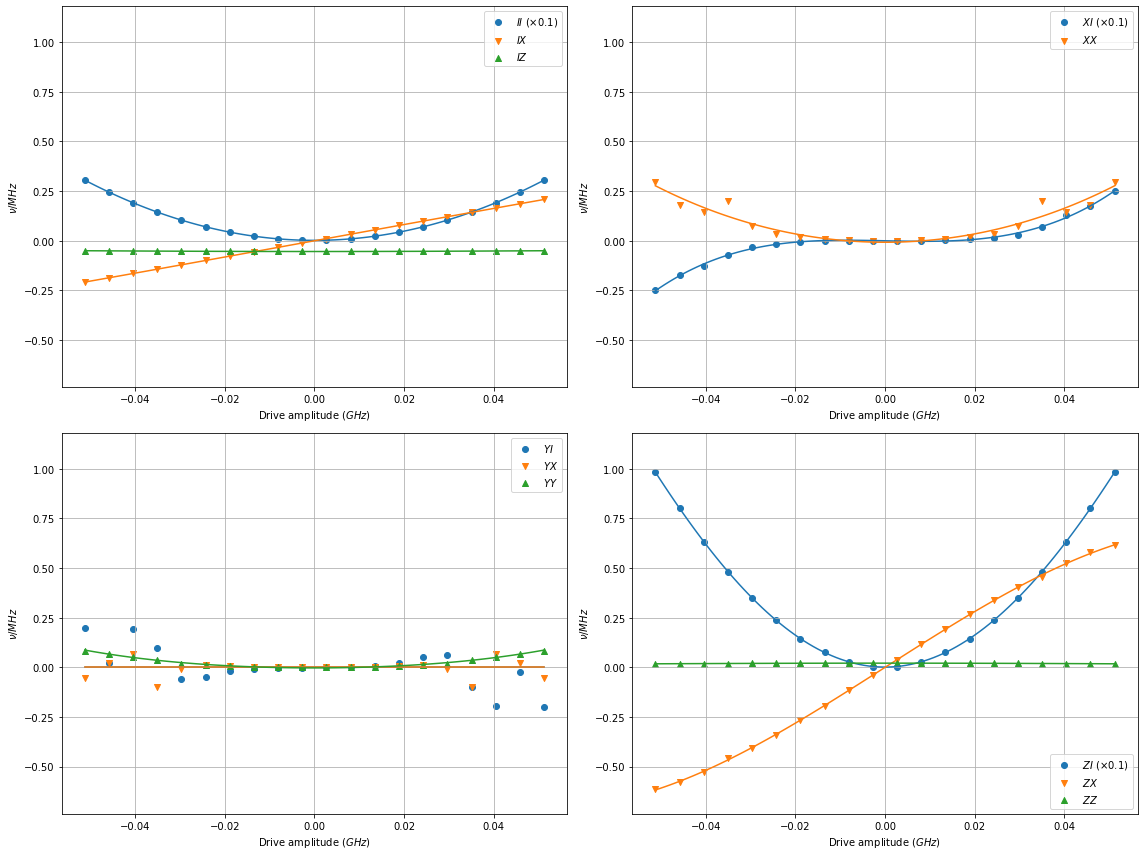

In [16]:
fig, exprs, amp_scale = plot_amplitude_scan(amplitudes * params['omegad0'], heff_scan, amp_scale=FrequencyScale.GHz)

In [17]:
print(f'A = Drive amplitude in {amp_scale.frequency_unit}')
Math(r' \\ '.join(exprs))

A = Drive amplitude in GHz


<IPython.core.display.Math object>

## [Demo 5] Qutrit cross resonance

First, inspect the Pauli components and the fit for a specific drive amplitude. To identify spurious fits, we run the simulation ten times longer than usual.

In [18]:
drive_def = {0: {'frequency': params['wq1'], 'amplitude': 0.2}}

find_heff(
    qubits=(0, 1),
    params=params,
    drive_def=drive_def,
    num_sim_levels=4,
    num_cycles=1000,
    comp_dim=3,
    save_result_to='qutrit_cr');

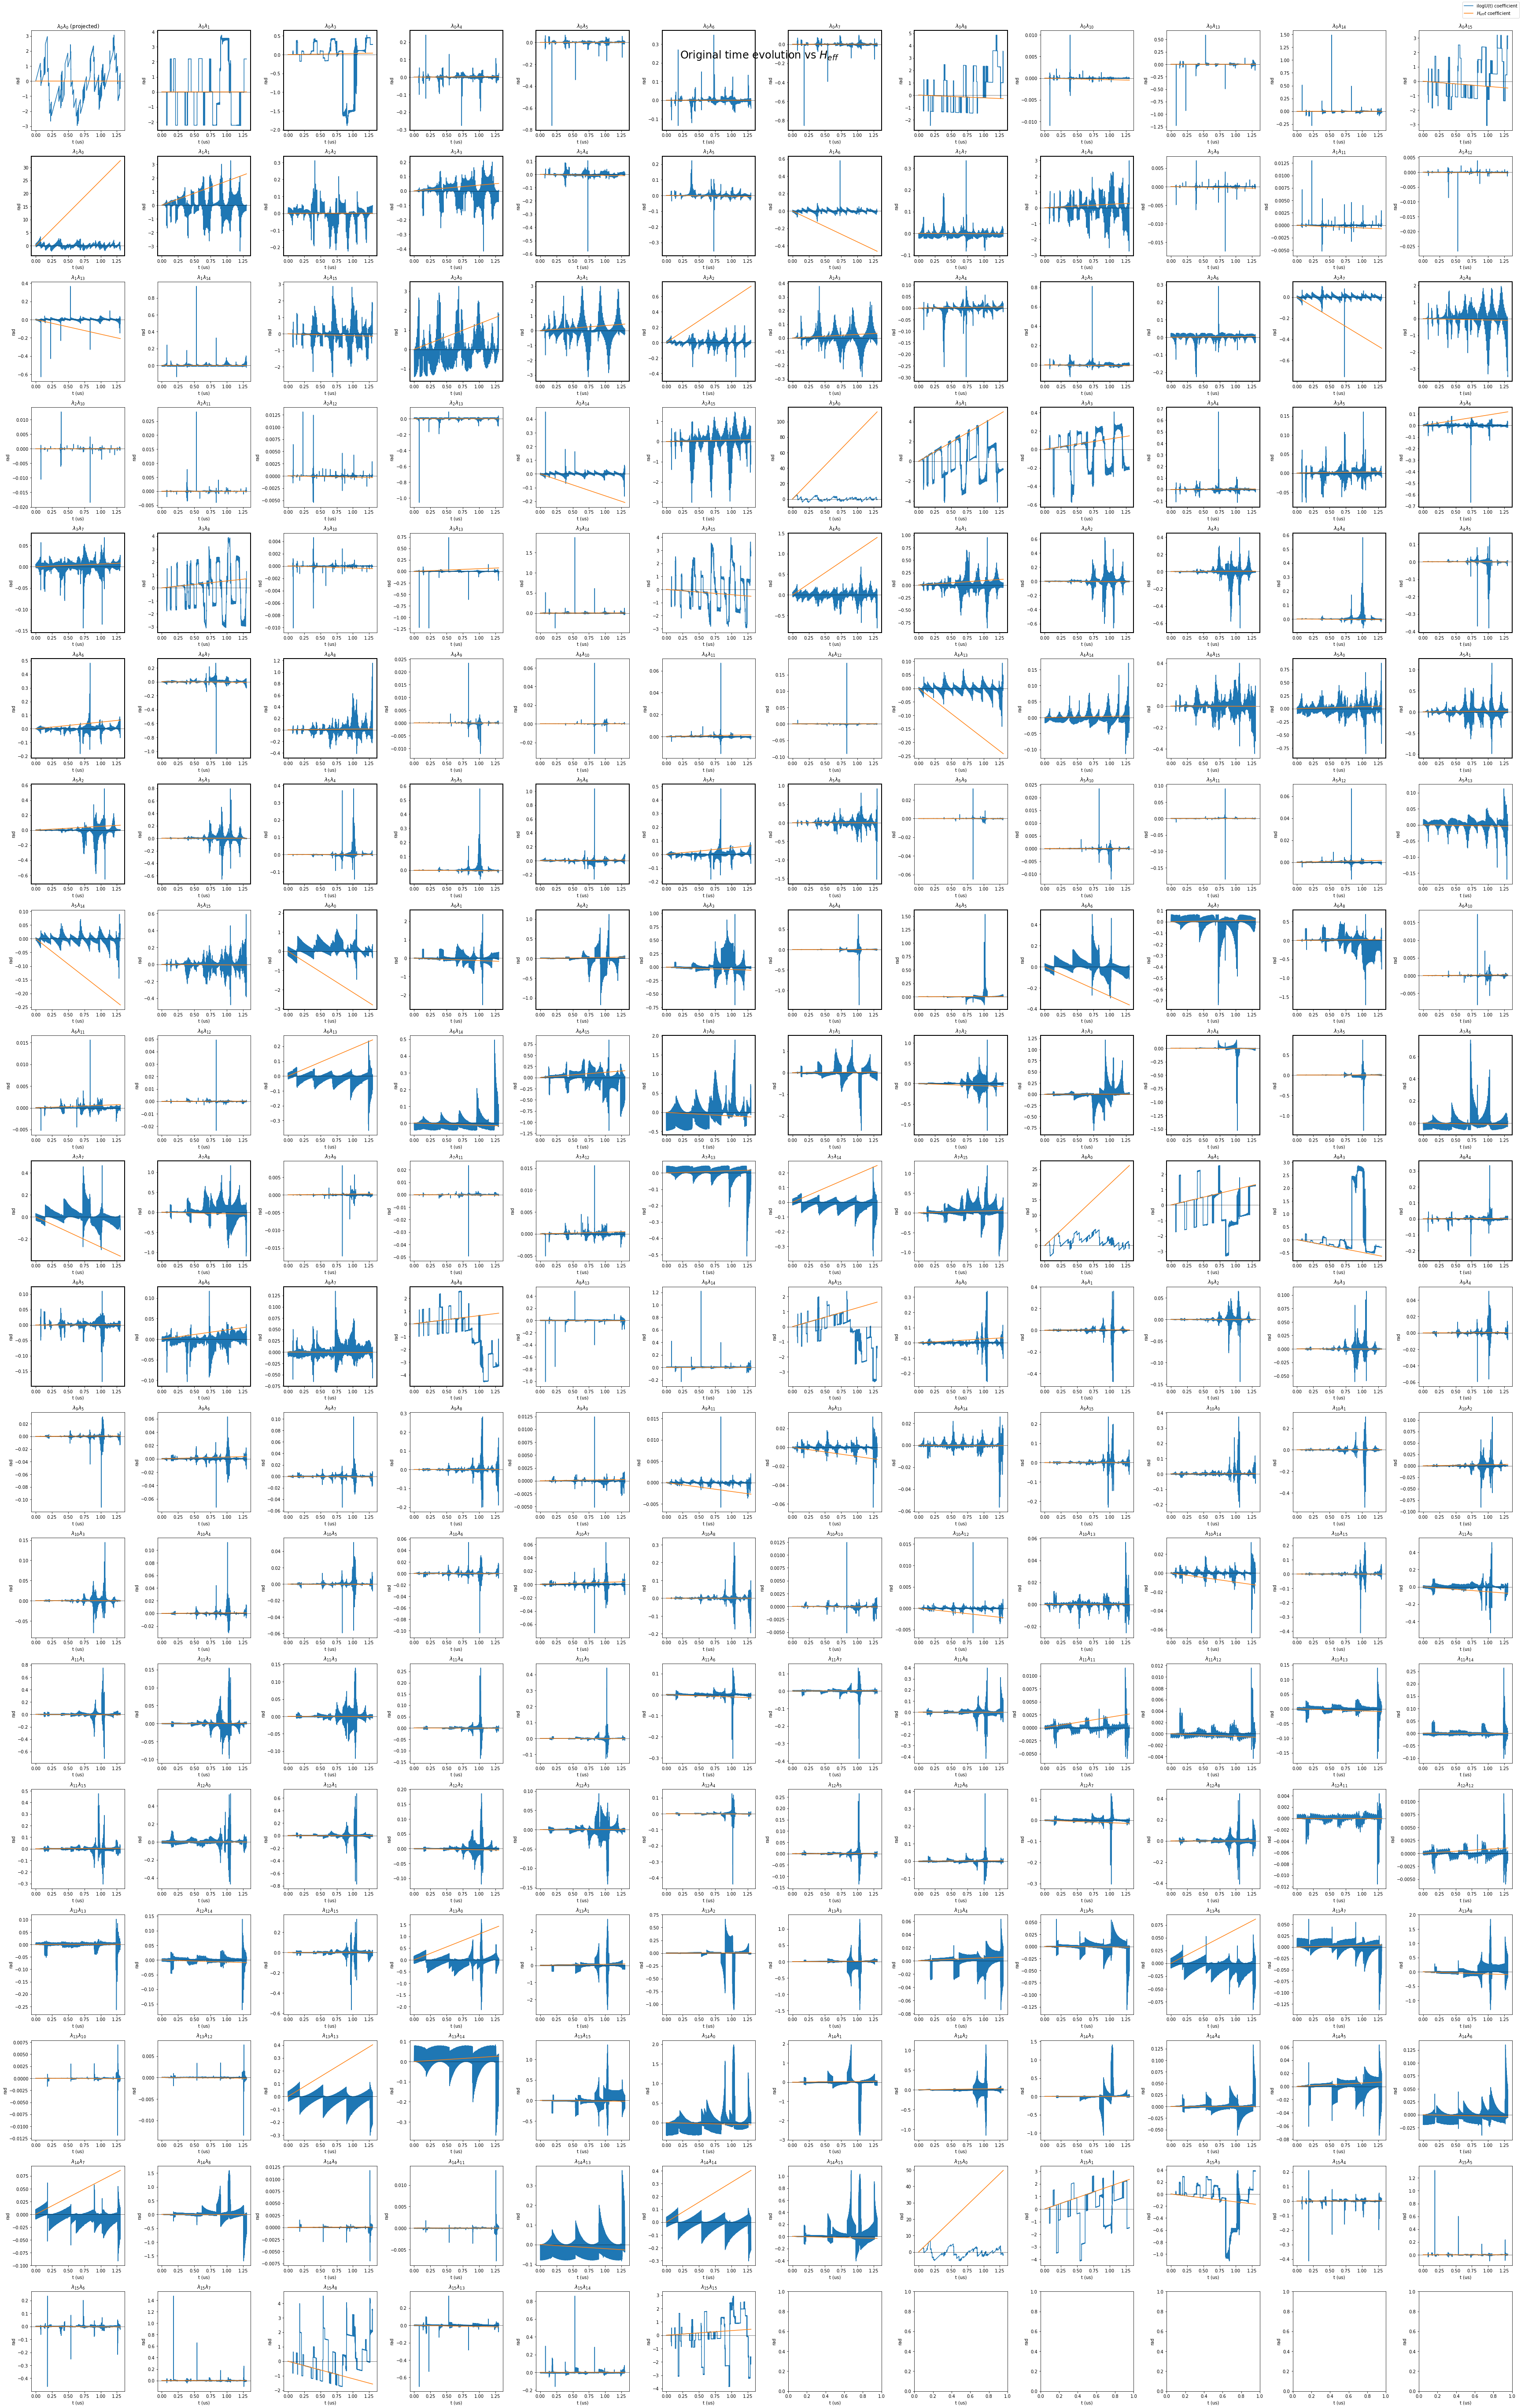

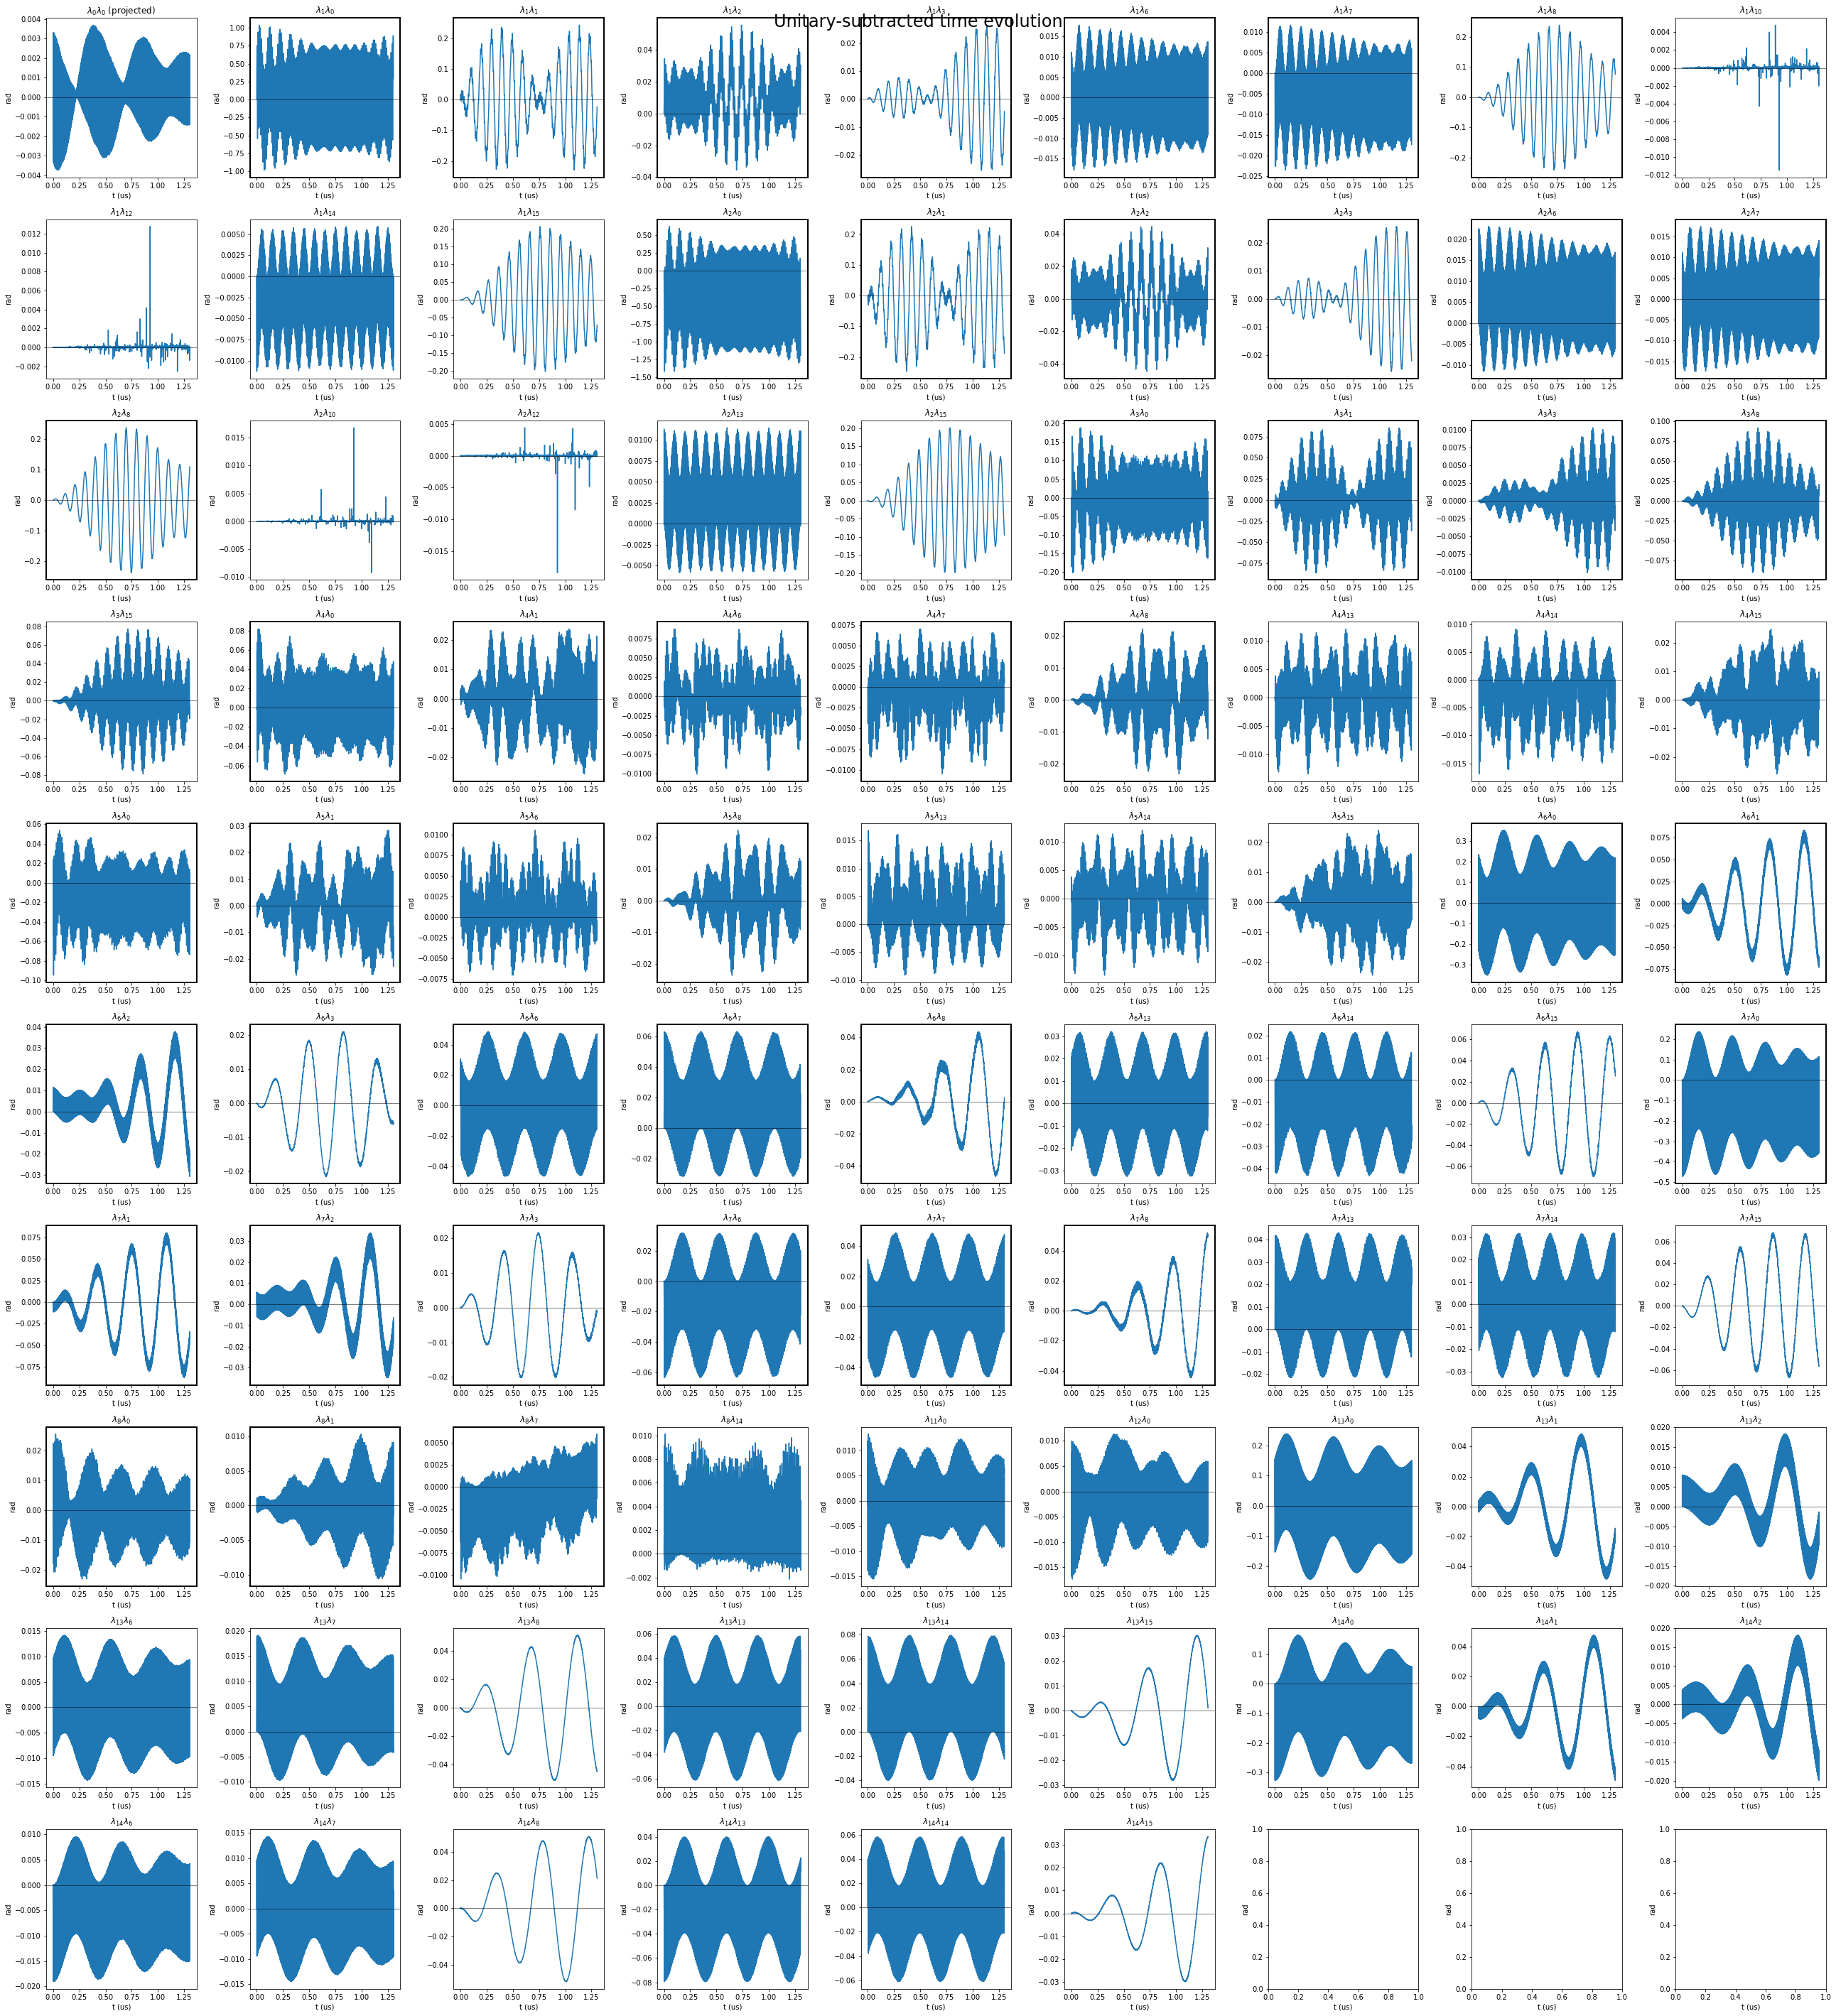

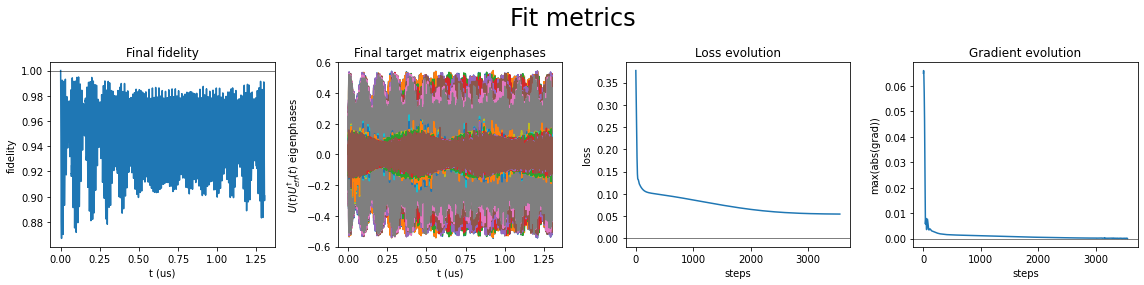

In [19]:
inspect_fidelity_maximization('qutrit_cr.h5');

Although we got a fair bit of residual fit warnings, the unitary-subtracted plots are mostly flat (components that are not shown have values smaller than 0.01rad everywhere) and so we can conclude that the Heff extraction worked.

Now we do the amplitude scan and also look at the Heff expression for drive with opposite polarities:

In [20]:
amplitudes = np.linspace(-0.2, 0.2, 20)

drive_def = list({0: {'frequency': params['wq1'], 'amplitude': amp}} for amp in amplitudes)

heff_qutrit_scan = find_heff(
    qubits=(0, 1),
    params=params,
    drive_def=drive_def,
    num_sim_levels=4,
    comp_dim=3,
    jax_devices=[0, 1])

In [21]:
Math(heff_expr(heff_qutrit_scan[0]))

<IPython.core.display.Math object>

In [22]:
Math(heff_expr(heff_qutrit_scan[-1]))

<IPython.core.display.Math object>

Coefficients sorted by amplitude

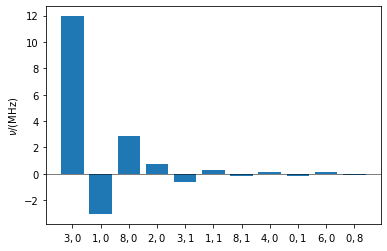

In [23]:
coeffs_bar(heff_qutrit_scan[0], threshold=-0.01); # negative value for threshold -> show above |threshold| * max

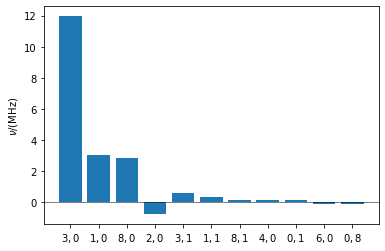

In [24]:
coeffs_bar(heff_qutrit_scan[-1], threshold=-0.01);

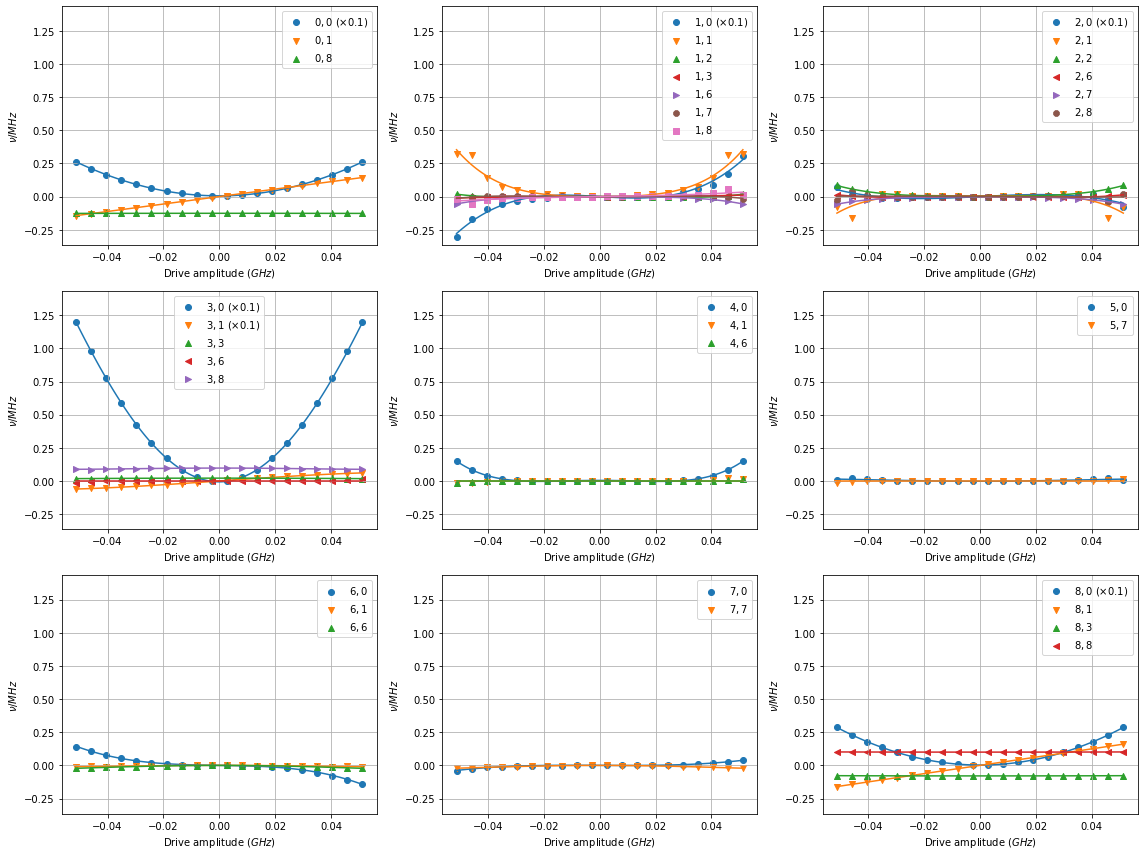

In [25]:
fig, exprs, amp_scale = plot_amplitude_scan(amplitudes * params['omegad0'], heff_qutrit_scan, amp_scale=FrequencyScale.GHz)

In [26]:
print(f'A = Drive amplitude in {amp_scale.frequency_unit}')
Math(r' \\ '.join(exprs))

A = Drive amplitude in GHz


<IPython.core.display.Math object>

## [Demo 6] Finding the $\pi$ pulse (not working right now)

`find_gate` computes the effective unitary (gate) of a given pulse and returns the Pauli coefficients of $i\log U_{\mathrm{eff}}$.

# "Grounded" gaussian pulse from -2 sigma to +2 sigma
sigma = 16 * 0.2e-9 # 16 clocks * 0.2 ns/clock
peak = 2. * sigma
pedestal = np.exp(-2.)
norm = 1. / (1. - pedestal)
envelope = f'(exp(-(t - {peak}) * (t - {peak}) / 2. / {sigma ** 2}) - {pedestal}) * {norm}'
tlist = np.linspace(0., 4. * sigma, 4000)

plt.plot(tlist, (np.exp(-(tlist - peak) * (tlist - peak) / 2. / (sigma ** 2)) - pedestal) * norm)

amplitudes = np.linspace(0., 1., 20)

x_coeff = np.empty_like(amplitudes)
z_coeff = np.empty_like(amplitudes)

for iamp, amp in enumerate(amplitudes):
    drive_def = {0: {'frequency': params['wq0'], 'amplitude': f'{amp} * {envelope}'}}

    rx_gate = find_gate(
        qubits=0,
        params=params,
        drive_def=drive_def,
        tlist=tlist,
        num_sim_levels=3,
        comp_dim=2
    )

    x_coeff[iamp] = rx_gate[1]
    z_coeff[iamp] = rx_gate[3]

plt.scatter(amplitudes, x_coeff)

The eigenvalues of $i \log U_{\mathrm{eff}}$ seemed to have jumped after the 10th point. Fit a line to data points before the jump.

popt, _ = sciopt.curve_fit(lambda x, a: a * x, amplitudes[:10], x_coeff[:10])

# pi pulse -> Ueff = exp(-i pi/2 X)
pipulse_amp = np.pi / 2. / popt[0]
print(f'Pi pulse realized at amplitude {pipulse_amp}')

plt.scatter(amplitudes, x_coeff)
plt.plot(amplitudes, popt[0] * amplitudes)
plt.axhline(y=(np.pi / 2.))
plt.axvline(x=pipulse_amp)

Of course, with higher levels included in the simulation, a simple Gaussian pulse no longer implements a pure $R_x$ gate.

plt.scatter(amplitudes, z_coeff)

### Running the pulse simulation by itself

The library also exposes the API to run a standalone dynamics simulation (a wrapper over qutip.sesolve).

# Initial state: qutrit |0>
psi0 = qtp.basis(3, 0)

# Track x, y, z extended to three dimensions
lambdas = make_generalized_paulis(3)
e_ops = [qtp.Qobj(inpt=lambdas[1]), qtp.Qobj(inpt=lambdas[2]), qtp.Qobj(inpt=lambdas[3])]

result = run_pulse_sim(
    qubits=(0,),
    params=params,
    drive_def=drive_def,
    psi0=psi0,
    tlist=(10, 100), # 10 time points per drive cycle * 100 cycles
    e_ops=e_ops)

# result is a qudit_sim.PulseSimResult object

plt.plot(result.times, result.expect[0], label=r'$\langle X \rangle$')
plt.plot(result.times, result.expect[1], label=r'$\langle Y \rangle$')
plt.plot(result.times, result.expect[2], label=r'$\langle Z \rangle$')
plt.title('Qubit time evolution')
plt.xlabel('time (s)')
plt.legend();